In [2]:
from torchvision.datasets import CelebA
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose

transform = Compose([
    Resize((218, 218)),
    ToTensor()
])

train = CelebA("data", "train", download=True, transform=transform)
valid = CelebA("data", "valid", download=True, transform=transform)
test = CelebA("data", "test", download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Number of pictures: 162770
Number of attributes: 40
Attribute names: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Resolution: torch.Size([3, 218, 218])


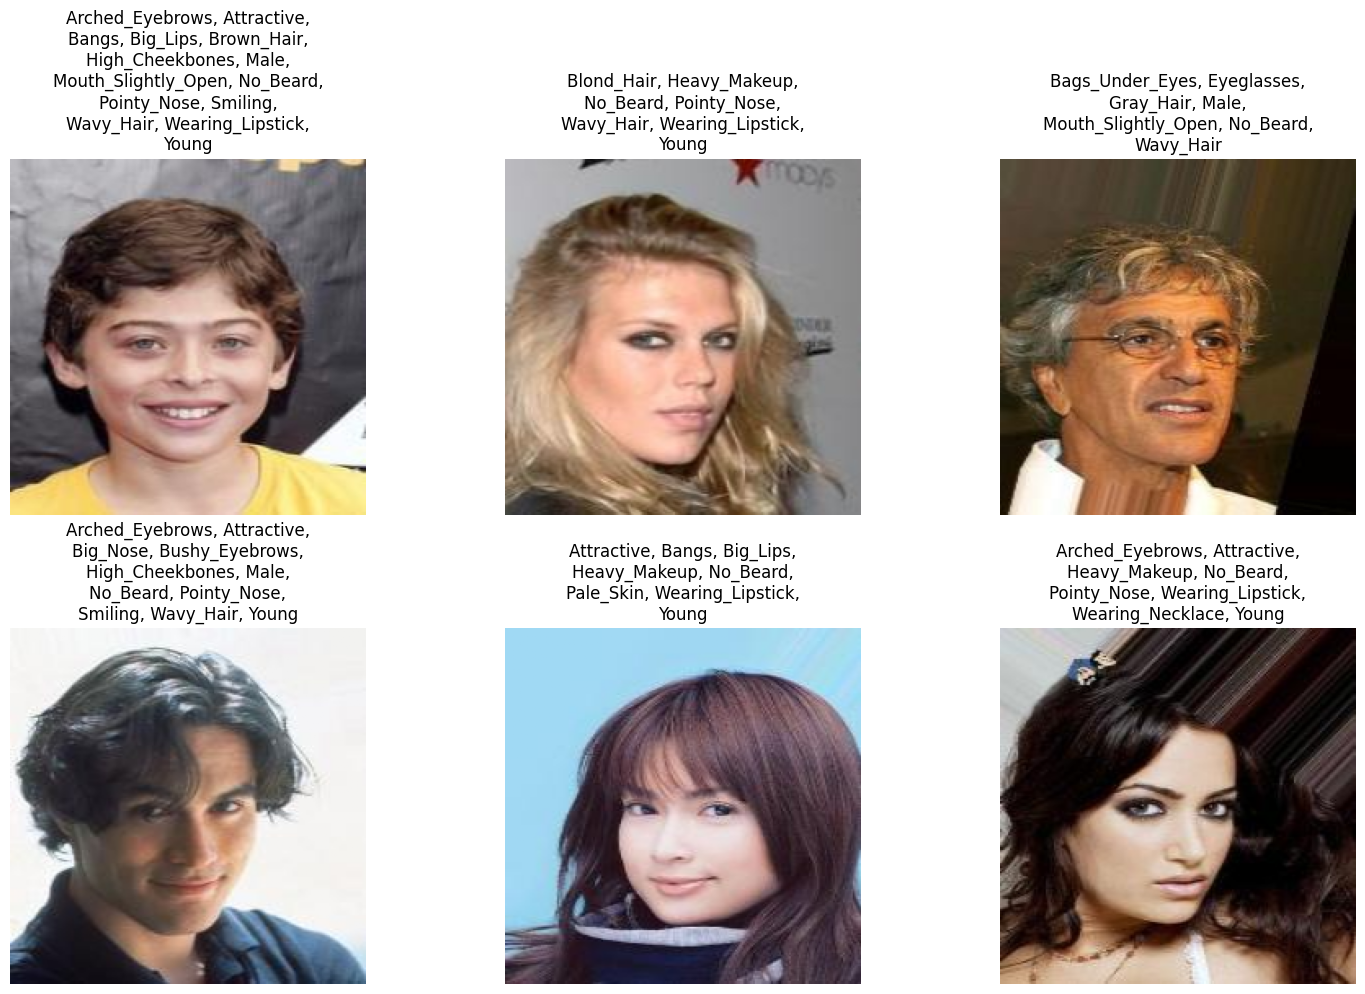

In [3]:
import matplotlib.pyplot as plt
import random
import textwrap

print(f"Number of pictures: {len(train)}")

print(f"Number of attributes: {len(train.attr_names[:-1])}")

print(f"Attribute names: {train.attr_names[:-1]}")

print(f"Resolution: {train[0][0].shape}")

# Define the number of rows and columns for the grid of images
ROWS = 2
COLS = 3

# Create subplots
fig, axs = plt.subplots(ROWS, COLS, figsize=(5*COLS, 5*ROWS))

# Randomly select images
selected_images = random.sample(range(len(train)), ROWS * COLS)

for i in range(ROWS * COLS):
    # Get attributes for the current image
    attrs = [attr for j, attr in enumerate(train.attr_names[:-1]) if train[selected_images[i]][1][j] == 1]
    
    # Calculate the row and column indices for the current image
    row = i // COLS
    col = i % COLS
    
    # Display the image
    axs[row, col].imshow(train[selected_images[i]][0].permute(1, 2, 0))

    # Remove the axes
    axs[row, col].axis('off')
    
    # Set the title to the attributes, with line breaks
    title = ", ".join(attrs)
    axs[row, col].set_title(textwrap.fill(title, 30))

# Show the plot
plt.tight_layout()
plt.show()

In [4]:
from efficientformer_v3 import EfficientFormerV3
from torchvision.transforms import ToTensor
from torch import cuda, backends

device = (
    "cuda"
    if cuda.is_available()
    else "mps"
    if backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

BATCH_SIZE = 64

model = EfficientFormerV3(batch_size=BATCH_SIZE).to(device)

print(model)

example = train[0][0].unsqueeze(0).to(device)
model.forward(example)


/home/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cyanosite/Development/Facial-Attribute-Recognition/model/efficientformer_v2.py:632: UserWarning: Overwriting efficientformerv2_s0 in registry with efficientformer_v2.efficientformerv2_s0. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/cyanosite/Development/Facial-Attribute-Recognition/model/efficientformer_v2.py:646: UserWarning: Overwriting efficientformerv2_s1 in registry with efficientformer_v2.efficientformerv2_s1. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/cyanosite/Development/Facial-Attribute-Recognit

Using cuda device
EfficientFormerV3(
  (network): Sequential(
    (0): EfficientFormerV2(
      (patch_embed): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GELU(approximate='none')
      )
      (network): ModuleList(
        (0): Sequential(
          (0): FFN(
            (mlp): Mlp(
              (fc1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
              (act): GELU(approximate='none')
              (fc2): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
              (drop): Dropout(p=0.0, inplace=False)
              (mid): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
         

tensor([[0.5074, 0.4898, 0.5166, 0.4962, 0.4900, 0.5116, 0.5061, 0.5063, 0.4961,
         0.5061, 0.4911, 0.4938, 0.5024, 0.4957, 0.4909, 0.5083, 0.5036, 0.4930,
         0.4923, 0.4941, 0.5050, 0.5116, 0.4945, 0.5033, 0.4975, 0.4991, 0.4966,
         0.5021, 0.5006, 0.5059, 0.4866, 0.4880, 0.5005, 0.5045, 0.5130, 0.4895,
         0.4988, 0.4942, 0.4935, 0.5006]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [5]:
from torch import nn, optim, save, load

loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

from efficientformer_v3 import train_loop, test_loop
train_loop(train_loader, model, loss_fn, optimizer, device, epochs=5)
save(model.state_dict(), "./data/trained.pth")

Epoch: 1/5 loss: 0.692381  [   64/162770]
Epoch: 1/5 loss: 0.678715  [ 6464/162770]
Epoch: 1/5 loss: 0.665325  [12864/162770]
Epoch: 1/5 loss: 0.642358  [19264/162770]
Epoch: 1/5 loss: 0.625381  [25664/162770]
Epoch: 1/5 loss: 0.604635  [32064/162770]
Epoch: 1/5 loss: 0.580494  [38464/162770]
Epoch: 1/5 loss: 0.561034  [44864/162770]
Epoch: 1/5 loss: 0.527801  [51264/162770]
Epoch: 1/5 loss: 0.504178  [57664/162770]
Epoch: 1/5 loss: 0.482246  [64064/162770]
Epoch: 1/5 loss: 0.486076  [70464/162770]
Epoch: 1/5 loss: 0.475354  [76864/162770]
Epoch: 1/5 loss: 0.454056  [83264/162770]
Epoch: 1/5 loss: 0.445386  [89664/162770]
Epoch: 1/5 loss: 0.458908  [96064/162770]
Epoch: 1/5 loss: 0.449757  [102464/162770]
Epoch: 1/5 loss: 0.445302  [108864/162770]
Epoch: 1/5 loss: 0.429236  [115264/162770]
Epoch: 1/5 loss: 0.447270  [121664/162770]
Epoch: 1/5 loss: 0.437863  [128064/162770]
Epoch: 1/5 loss: 0.435534  [134464/162770]
Epoch: 1/5 loss: 0.431947  [140864/162770]
Epoch: 1/5 loss: 0.438550  

In [6]:
model = EfficientFormerV3(batch_size=BATCH_SIZE)
model.load_state_dict(load("./data/trained.pth"))
model.to(device)

test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_loop(test_loader, model, loss_fn, device)

Test Error: 
 Accuracy: 82.8%, Avg loss: 0.386544 



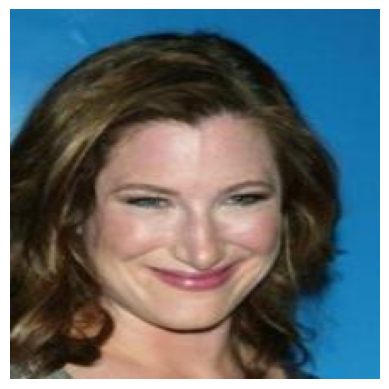

actual attributes: ['Attractive', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Smiling', 'Wavy_Hair', 'Wearing_Lipstick', 'Young']
expected attributes: ['Attractive', 'Heavy_Makeup', 'High_Cheekbones', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pointy_Nose', 'Smiling', 'Wavy_Hair', 'Wearing_Lipstick', 'Young']


In [17]:
SAMPLE = 456

example = test[SAMPLE][0]

plt.imshow(example.permute(1, 2, 0))
plt.axis("off")
plt.show()

output = model.forward(example.unsqueeze(0).to(device))
new_attributes = ['Attractive', 'Blurry', 'Chubby', 'Heavy_Makeup', 'Male', 'Oval_Face', 'Pale_Skin', 'Smiling', 'Young', 'Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Receding_Hairline', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Hat', 'Arched_Eyebrows', 'Bags_Under_Eyes', 'Bushy_Eyebrows', 'Eyeglasses', 'Narrow_Eyes', 'Big_Nose', 'Pointy_Nose', '5_o_Clock_Shadow', 'Big_Lips', 'Double_Chin', 'Goatee', 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Sideburns', 'Wearing_Lipstick', 'High_Cheekbones', 'Rosy_Cheeks', 'Wearing_Earrings', 'Wearing_Necklace', 'Wearing_Necktie']
actual = sorted((attr for i, attr in enumerate(new_attributes) if output[0][i] > 0.5))
print(f"actual attributes: {actual}")

attributes = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
expected = sorted((attr for i, attr in enumerate(attributes) if test[SAMPLE][1][i] == 1))
print(f"expected attributes: {expected}")

In [18]:
import torch
import torchvision

example = example.unsqueeze(0).to(device)

@torch.no_grad()
def trace(model, example):
    model.eval()
    return torch.jit.trace(model, example)
traced_model = trace(model, example)
out = traced_model(example)

import coremltools as ct


# Using image_input in the inputs parameter:
# Convert to Core ML program using the Unified Conversion API.
model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=example.shape)]
 )

# Save the converted model.
model.save("newmodel.mlpackage")

Torch version 2.2.1+cu121 has not been tested with coremltools. You may run into unexpected errors. Torch 2.1.0 is the most recent version that has been tested.
Running MIL default pipeline:  14%|█▍        | 10/71 [00:00<00:00, 65.11 passes/s]/home/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:239: UserWarning: Input, 'x.1', of the source model, has been renamed to 'x_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
/home/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:267: UserWarning: Output, '1607', of the source model, has been renamed to 'var_1607' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 285.68 passes/s]
